<b>The raw dataset obtained, was given names for each column and saved as Nepali_dataset inside folder named raw in Data. This process was done in notebook Romanizing_test. Nepali_dataset was further transformed by generating embeddings for "Text" using encoders like Word2Vec in notebook Create_embeddings_for_df and the classification ready dataset is saved in Preprocessed</b>

In [1]:
#library import
import pandas as pd # for data manipulation and analysis
import numpy as np # for scientific computing with Python
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline
import seaborn as sns # for advanced visualization


In [2]:
df= pd.read_csv('../Data/Preprocessed/pretrained_word2vec_df.csv')
df_word2vec= df.copy()
df_word2vec.head(2)


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Target
0,-0.353896,-0.362858,-0.423552,1.104782,-0.010077,0.141672,0.289903,0.133494,-0.097301,-0.684760,...,-1.099061,0.555198,-0.914626,0.487582,-0.510756,0.030198,0.281444,-0.032571,-0.526055,2
1,0.024839,-0.276190,-0.076623,0.665478,0.056230,0.578328,-0.236490,0.222671,-0.147569,-0.263676,...,-0.036520,0.926974,0.483738,0.741491,-0.771113,-0.622755,0.375458,0.073563,0.495352,3


In [3]:
from sklearn import metrics
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report


In [4]:
'''Splitting The df into train test val split at ratio 8:1:1 
Which is done default(although the ratio passable) by custom script train_test_val_split.py'''

from train_test_val_split import train_test_val_split

X_train_word2vec, X_test_word2vec, X_val_word2vec, y_train_word2vec, y_test_word2vec, y_val_word2vec = train_test_val_split(df_word2vec, test_size=0.15, val_size=0.15)



Shape of feature vectors (X): (4035, 300)
Shape of target labels (y): (4035,)


In [5]:
X_train_word2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1897,-0.237771,-1.097349,0.565440,0.400734,-1.626643,0.316942,0.462526,0.482782,-0.812611,-0.103100,...,-0.354521,-0.759254,-0.248032,-0.035407,0.354255,-0.567030,-1.736737,0.497475,-0.540203,-0.595362
4016,0.072453,-0.075744,-0.084089,-0.272046,-0.418390,0.402013,-0.518639,0.246257,0.438428,-0.851450,...,-0.562878,-0.412216,0.360441,0.524712,0.226830,-1.506123,-0.980817,0.950002,0.331286,0.472423
2199,0.181570,-0.487602,0.033546,0.201078,0.263859,0.412969,0.174405,0.517388,0.425964,0.166303,...,-0.439616,-0.860327,-0.037205,-0.318438,1.229942,-0.382137,-0.253601,-0.323670,-0.303982,-0.394168
1557,0.699618,-0.041581,-0.267969,0.196721,-0.206327,0.199916,0.760806,0.316445,-0.047377,-0.718592,...,-0.231238,-0.506145,0.195218,0.181051,0.417971,0.109003,-0.074975,0.113749,-0.310980,0.346112
3171,-0.192478,-0.470273,-0.596840,0.180144,-1.095866,0.811246,-0.170719,0.905819,-0.370684,-1.380032,...,-0.695633,0.030132,-0.381385,0.536838,2.299293,-0.157051,0.249596,-0.156383,-0.323900,0.023497


check Model_training_v1 to know target encodeding
- FEEDBACK_0: 0
- FEEDBACK_1: 1
- GENERAL_0: 2
- GENERAL_1: 3
- PROFANITY_0: 4
- PROFANITY_1: 5
- VIOLENCE_0: 6
- VIOLENCE_1: 7

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_word2vec), y=y_train_word2vec)
class_weights_dict = dict(enumerate(class_weights))

# Training SVC

svc_model = SVC(probability=True, class_weight=class_weights_dict, random_state=42)
svc_model.fit(X_train_word2vec,y_train_word2vec)


SVC(class_weight={0: 1.1806020066889633, 1: 6.418181818181818,
                  2: 0.47831978319783197, 3: 0.28330658105939005,
                  4: 1.6650943396226414, 5: 4.835616438356165, 6: 4.4125,
                  7: 2.9173553719008263},
    probability=True, random_state=42)

In [7]:
# Function to evaluate model and returns target predictions 
def make_scores(model, features, target):
    model_pred = model.predict(features)

    print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(model_pred , target))) 

    roc_auc = metrics.roc_auc_score(target , model.predict_proba(features), multi_class='ovr')
    print('AUC : {0:0.5f}'.format(roc_auc))

    print('Precision : {0:0.5f}'.format(metrics.precision_score(target , model_pred, average='macro')))
    print('Recall : {0:0.5f}'.format(metrics.recall_score(target , model_pred, average='macro')))
    print('F1 : {0:0.5f}'.format(metrics.f1_score(target , model_pred, average='macro')))
    print(classification_report(target, model_pred))
    
    return model_pred

# Scores of SVC
svc_pred=make_scores(svc_model, X_test_word2vec, y_test_word2vec)

Accuracy :0.46942
AUC : 0.81206
Precision : 0.31992
Recall : 0.38993
F1 : 0.33104
              precision    recall  f1-score   support

           0       0.40      0.45      0.42        64
           1       0.00      0.00      0.00        12
           2       0.66      0.67      0.66       158
           3       0.72      0.41      0.53       267
           4       0.20      0.31      0.25        45
           5       0.16      0.44      0.23        16
           6       0.21      0.41      0.27        17
           7       0.22      0.42      0.29        26

    accuracy                           0.47       605
   macro avg       0.32      0.39      0.33       605
weighted avg       0.57      0.47      0.49       605



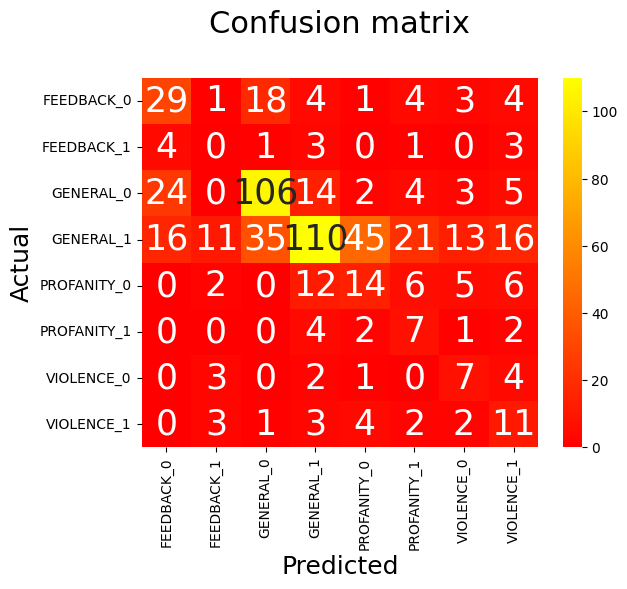

In [8]:
# Heatmap for Confusion Matrix
def make_confusion_matrix(target, prediction):
    cnf_matrix = metrics.confusion_matrix(target,prediction)
    cnf_matrix_df = pd.DataFrame(cnf_matrix,
                         index = ['FEEDBACK_0','FEEDBACK_1','GENERAL_0','GENERAL_1','PROFANITY_0','PROFANITY_1','VIOLENCE_0','VIOLENCE_1'], 
                         columns = ['FEEDBACK_0','FEEDBACK_1','GENERAL_0','GENERAL_1','PROFANITY_0','PROFANITY_1','VIOLENCE_0','VIOLENCE_1'])
    p = sns.heatmap(cnf_matrix_df, annot=True, annot_kws={"size": 25}, cmap="autumn" ,fmt='g')

    plt.title('Confusion matrix', y=1.1, fontsize = 22)
    plt.ylabel('Actual',fontsize = 18)
    plt.xlabel('Predicted',fontsize = 18)
    plt.show()

# Confusion Matrix for SVC
make_confusion_matrix(y_test_word2vec,svc_pred)

## Ok the model performs horrible, before tuning the model let's try PCA

In [9]:
import pandas as pd
from sklearn.decomposition import PCA

# Define the number of principal components
n_components = 50
pca = PCA(n_components=n_components)

# Apply PCA on the training set 
X_train_word2vec_pca = pca.fit_transform(X_train_word2vec)

# Transform the validation and test sets using the same PCA model
X_val_word2vec_pca = pca.transform(X_val_word2vec)
X_test_word2vec_pca = pca.transform(X_test_word2vec)

# Convert PCA results to DataFrames
X_train_word2vec_pca_df = pd.DataFrame(X_train_word2vec_pca, columns=[f"PC{i+1}" for i in range(n_components)])
X_val_word2vec_pca_df = pd.DataFrame(X_val_word2vec_pca, columns=[f"PC{i+1}" for i in range(n_components)])
X_test_word2vec_pca_df = pd.DataFrame(X_test_word2vec_pca, columns=[f"PC{i+1}" for i in range(n_components)])

print(X_train_word2vec_pca_df.head(1))


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -5.276258 -0.619637  2.877795 -1.308064 -1.521848  0.748404  2.277933   

        PC8       PC9      PC10  ...      PC41      PC42      PC43      PC44  \
0  1.528218 -0.671988  0.877543  ...  0.673417  1.450051 -1.707518 -1.014967   

       PC45      PC46      PC47      PC48      PC49      PC50  
0 -0.464466  0.555359 -0.025374 -0.217059 -0.211914 -1.490976  

[1 rows x 50 columns]


Accuracy :0.45620
AUC : 0.79745
Precision : 0.32693
Recall : 0.40551
F1 : 0.33801
              precision    recall  f1-score   support

           0       0.36      0.39      0.38        64
           1       0.17      0.25      0.20        12
           2       0.66      0.69      0.68       158
           3       0.71      0.37      0.49       267
           4       0.20      0.31      0.24        45
           5       0.13      0.38      0.19        16
           6       0.15      0.35      0.21        17
           7       0.24      0.50      0.32        26

    accuracy                           0.46       605
   macro avg       0.33      0.41      0.34       605
weighted avg       0.56      0.46      0.48       605



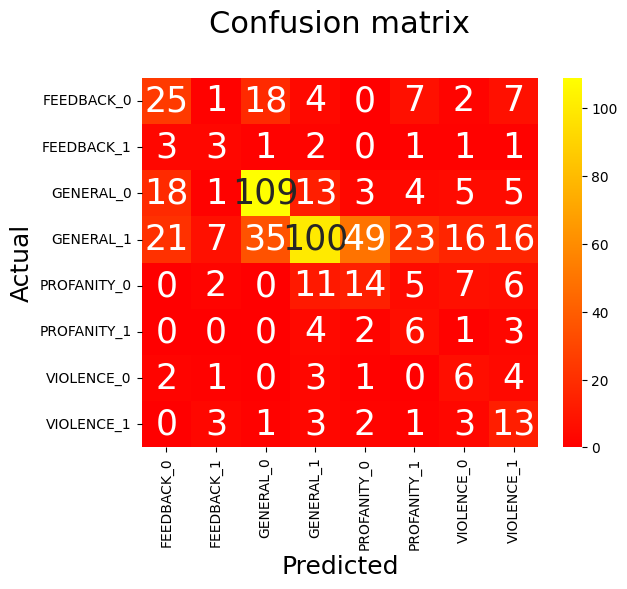

In [10]:
# Training SVC_pca

svc_model_pca = SVC(probability=True, class_weight=class_weights_dict, random_state=42)
svc_model_pca.fit(X_train_word2vec_pca,y_train_word2vec)

# Scores of SVC_pca
svc_pca_pred=make_scores(svc_model_pca, X_test_word2vec_pca, y_test_word2vec)

# Confusion Matrix for SVC_pca
make_confusion_matrix(y_test_word2vec,svc_pca_pred)

Ok even PCA doesn't help SVM. Now, let's try AdaBoost

Accuracy :0.40331
AUC : 0.71242
Precision : 0.25893
Recall : 0.28541
F1 : 0.26591
              precision    recall  f1-score   support

           0       0.20      0.23      0.22        64
           1       0.09      0.08      0.09        12
           2       0.54      0.59      0.57       158
           3       0.56      0.40      0.47       267
           4       0.15      0.29      0.20        45
           5       0.00      0.00      0.00        16
           6       0.29      0.41      0.34        17
           7       0.23      0.27      0.25        26

    accuracy                           0.40       605
   macro avg       0.26      0.29      0.27       605
weighted avg       0.44      0.40      0.41       605



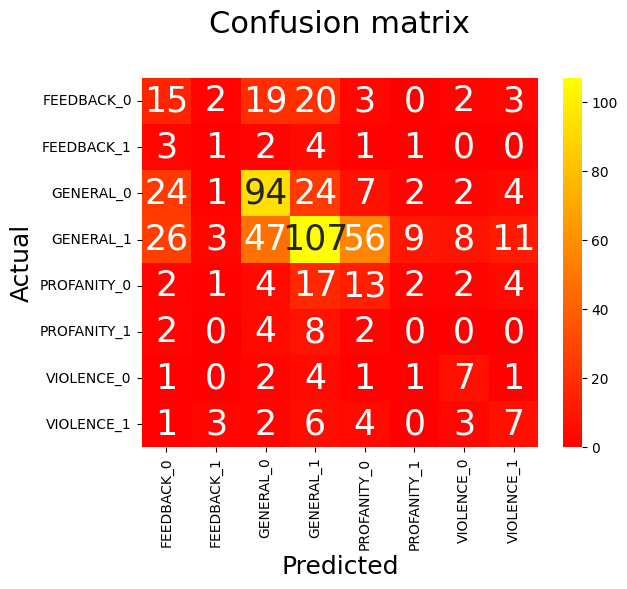

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42) 
ada_classifier.fit(X_train_word2vec, y_train_word2vec, sample_weight=[class_weights_dict[y] for y in y_train_word2vec])

ada_classifier_pred= make_scores(ada_classifier, X_test_word2vec, y_test_word2vec)
make_confusion_matrix(y_test_word2vec,ada_classifier_pred)


Clearly AdaBoost didn't work well either. Why not try word2vec model made from our own dataset

In [12]:
df= pd.read_csv('../Data/Preprocessed/word2vec_df.csv')
df_word2vec= df.copy()
df_word2vec.head(2)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Target
0,-0.232668,0.454456,0.377842,0.232187,-0.111215,-0.574158,0.196363,1.015102,-0.608925,-0.391485,...,-0.106739,0.301462,0.026194,1.040798,0.283798,0.329874,-0.286696,0.271906,0.035611,2
1,-0.231003,0.450847,0.373016,0.224788,-0.106883,-0.568405,0.193457,1.001529,-0.599364,-0.391566,...,-0.103629,0.294274,0.024000,1.027592,0.279513,0.330153,-0.282997,0.266399,0.033298,3


In [13]:
X_train_word2vec, X_test_word2vec, X_val_word2vec, y_train_word2vec, y_test_word2vec, y_val_word2vec = train_test_val_split(df_word2vec)

Shape of feature vectors (X): (4035, 100)
Shape of target labels (y): (4035,)


Accuracy :0.06203
AUC : 0.53929


/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/a

Precision : 0.06414
Recall : 0.12348
F1 : 0.03968
              precision    recall  f1-score   support

           0       0.07      0.05      0.06        43
           1       0.00      0.00      0.00         8
           2       0.38      0.09      0.14       105
           3       0.00      0.00      0.00       178
           4       0.00      0.00      0.00        30
           5       0.02      0.09      0.03        11
           6       0.00      0.00      0.00        11
           7       0.05      0.76      0.09        17

    accuracy                           0.06       403
   macro avg       0.06      0.12      0.04       403
weighted avg       0.11      0.06      0.05       403



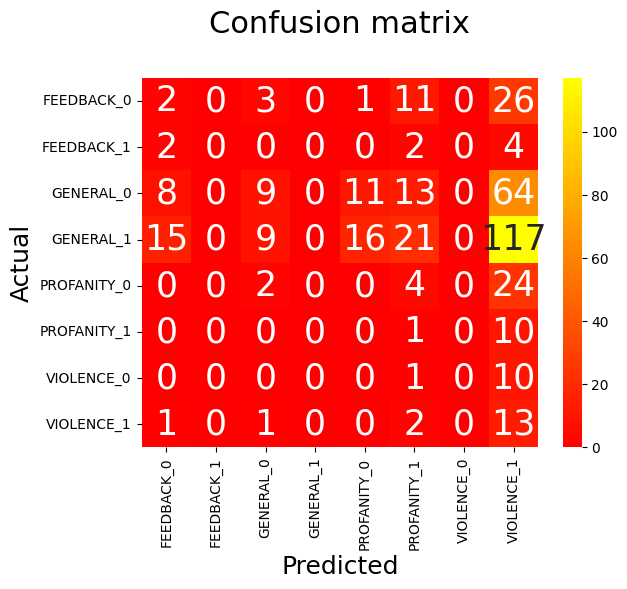

In [14]:
# Training SVC

svc_model = SVC(probability=True, class_weight=class_weights_dict, random_state=42)
svc_model.fit(X_train_word2vec,y_train_word2vec)

# Scores of SVC
svc_pred=make_scores(svc_model, X_test_word2vec, y_test_word2vec)

# Confusion Matrix for SVC
make_confusion_matrix(y_test_word2vec,svc_pred)


doesn't look good again, should try hyperparameters tuning later. let's try PCA 

In [15]:
import pandas as pd
from sklearn.decomposition import PCA

# Define the number of principal components
n_components = 50
pca = PCA(n_components=n_components)

# Apply PCA on the training set 
X_train_word2vec_pca = pca.fit_transform(X_train_word2vec)

# Transform the validation and test sets using the same PCA model
X_val_word2vec_pca = pca.transform(X_val_word2vec)
X_test_word2vec_pca = pca.transform(X_test_word2vec)

# Convert PCA results to DataFrames
X_train_word2vec_pca_df = pd.DataFrame(X_train_word2vec_pca, columns=[f"PC{i+1}" for i in range(n_components)])
X_val_word2vec_pca_df = pd.DataFrame(X_val_word2vec_pca, columns=[f"PC{i+1}" for i in range(n_components)])
X_test_word2vec_pca_df = pd.DataFrame(X_test_word2vec_pca, columns=[f"PC{i+1}" for i in range(n_components)])

Accuracy :0.10918
AUC : 0.56876
Precision : 0.08478
Recall : 0.19614
F1 : 0.08503
              precision    recall  f1-score   support

           0       0.17      0.37      0.24        43
           1       0.00      0.00      0.00         8
           2       0.33      0.11      0.17       105
           3       0.00      0.00      0.00       178
           4       0.05      0.07      0.06        30
           5       0.05      0.55      0.09        11
           6       0.00      0.00      0.00        11
           7       0.07      0.47      0.13        17

    accuracy                           0.11       403
   macro avg       0.08      0.20      0.09       403
weighted avg       0.11      0.11      0.08       403



/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/angel-tamang/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/a

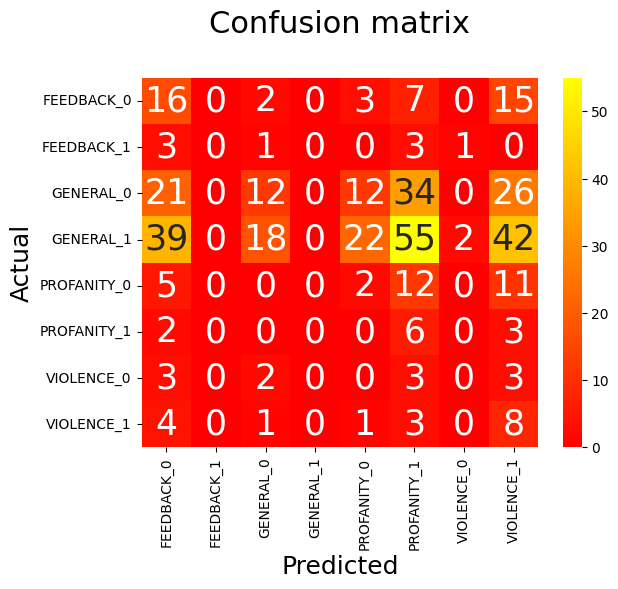

In [16]:
# Training SVC_pca

svc_model_pca = SVC(probability=True, class_weight=class_weights_dict)
svc_model_pca.fit(X_train_word2vec_pca,y_train_word2vec)

# Scores of SVC_pca
svc_pca_pred=make_scores(svc_model_pca, X_test_word2vec_pca, y_test_word2vec)

# Confusion Matrix for SVC_pca
make_confusion_matrix(y_test_word2vec,svc_pca_pred)

ADAboostClassifier

Accuracy :0.27792
AUC : 0.60728
Precision : 0.18838
Recall : 0.18039
F1 : 0.16704
              precision    recall  f1-score   support

           0       0.12      0.21      0.16        43
           1       0.00      0.00      0.00         8
           2       0.56      0.26      0.35       105
           3       0.51      0.36      0.42       178
           4       0.11      0.20      0.14        30
           5       0.07      0.09      0.08        11
           6       0.04      0.09      0.05        11
           7       0.09      0.24      0.13        17

    accuracy                           0.28       403
   macro avg       0.19      0.18      0.17       403
weighted avg       0.40      0.28      0.31       403



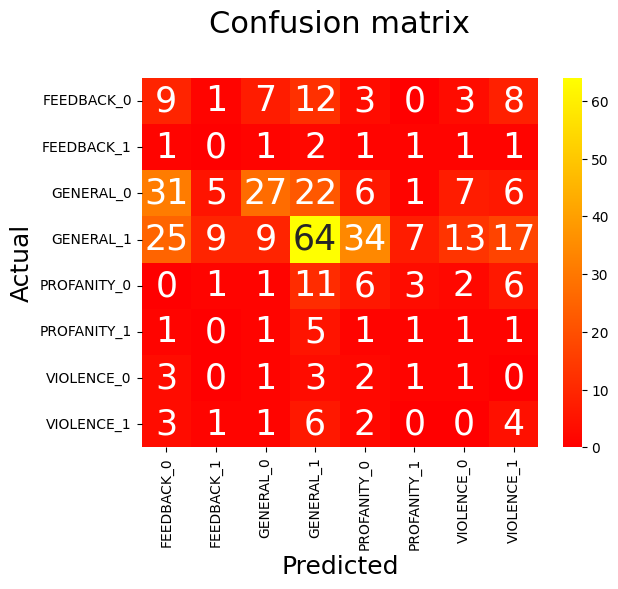

In [17]:
ada_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=42) 
ada_classifier.fit(X_train_word2vec, y_train_word2vec, sample_weight=[class_weights_dict[y] for y in y_train_word2vec])

ada_classifier_pred= make_scores(ada_classifier, X_test_word2vec, y_test_word2vec)
make_confusion_matrix(y_test_word2vec,ada_classifier_pred)

AdaBoost with PCA

Accuracy :0.39702
AUC : 0.66836
Precision : 0.25721
Recall : 0.29756
F1 : 0.25982
              precision    recall  f1-score   support

           0       0.20      0.26      0.22        43
           1       0.00      0.00      0.00         8
           2       0.60      0.50      0.55       105
           3       0.62      0.39      0.48       178
           4       0.26      0.63      0.37        30
           5       0.13      0.18      0.15        11
           6       0.11      0.18      0.14        11
           7       0.13      0.24      0.17        17

    accuracy                           0.40       403
   macro avg       0.26      0.30      0.26       403
weighted avg       0.48      0.40      0.42       403



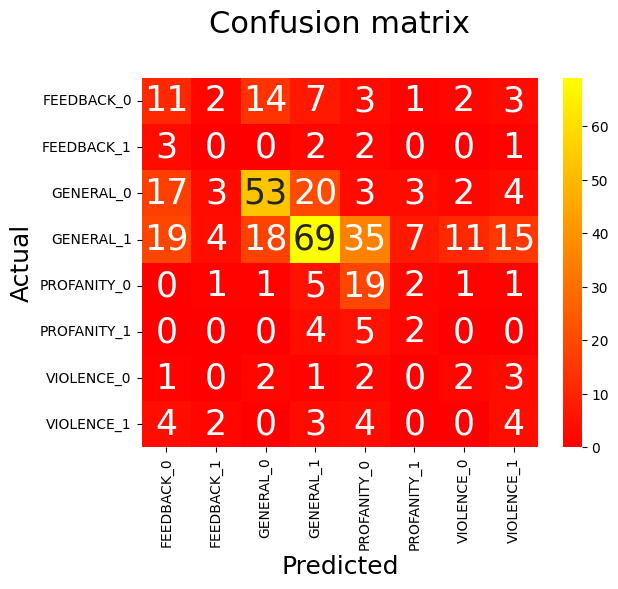

In [18]:
ada_classifier_pca = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),n_estimators=100, random_state=42) 
ada_classifier_pca.fit(X_train_word2vec_pca, y_train_word2vec, sample_weight=[class_weights_dict[y] for y in y_train_word2vec])

ada_classifier_pca_pred= make_scores(ada_classifier_pca, X_test_word2vec_pca, y_test_word2vec)
make_confusion_matrix(y_test_word2vec,ada_classifier_pca_pred)